# Importation des bibliothèques nécessaires
```python

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier


## Nettoyage et préparation des données
Nous allons charger les données, nettoyer les colonnes inutiles et gérer les types de données incorrects.
```python

In [25]:

def clean_and_prepare_data(data):
    columns_to_drop = ['département', 'circonscription', 'Code département', 'Inscrits', 'Votants', 'Exprimés', 'Blancs et nuls']
    data = data.drop(columns=columns_to_drop)
    for col in data.columns:
        if data[col].dtype == object:
            data[col] = data[col].str.replace(',', '.').astype(float)
    return data

data = pd.read_parquet('../dataset/dataframe_politique_pouvoir_achat_chomage.parquet')
data = clean_and_prepare_data(data)


## Sélection des caractéristiques et cibles
Nous sélectionnons les variables explicatives et les cibles pour la formation des modèles.
```python

In [26]:
X = data[['Chomage', 'Pouvoir d’achat du revenu disponible brut', 'Pouvoir d\'achat par unité de consommation']]
y = data[['Extrême gauche_Pct', 'Gauche_Pct', 'Droite_Pct', 'Extrême droite_Pct']]


## Transformation des cibles en classes
Cette fonction transforme les pourcentages en classes catégoriques pour la classification.
```python

In [27]:
def transform_to_classes(y):
    bins = [0, 25, 50, 75, 100]
    labels = [0, 1, 2, 3]
    y_classes = pd.cut(y, bins=bins, labels=labels, include_lowest=True)
    return y_classes.astype(int)

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_class = y_train.apply(transform_to_classes)
y_test_class = y_test.apply(transform_to_classes)


## Entraînement du modèle RandomForest
Nous entraînons un modèle de régression et de classification RandomForest.
```python

In [28]:
# Régression
regressor = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)
try:
    regressor.fit(X_train, y_train_class)
except Exception as e:
    print(f"Error training model: {e}")

# Classification
classifier = RandomForestClassifier(n_estimators=10, max_depth=3, random_state=42)
classifier.fit(X_train, y_train_class)

RandomForestClassifier(max_depth=3, n_estimators=10, random_state=42)

In [29]:
# Perform cross-validation
scores = cross_val_score(regressor, X, y.apply(transform_to_classes), cv=5)  # Adjust cv depending on your sample size
print("Cross-validated scores:", scores)
print("Average score:", np.mean(scores))
print("Feature Importances:", regressor.feature_importances_)


Cross-validated scores: [-1.01773437 -1.09722222 -0.07       -0.25        0.213975  ]
Average score: -0.4441963194444445
Feature Importances: [0.27602927 0.17365934 0.55031138]


## Prédiction et évaluation du modèle
Nous évaluons le modèle en utilisant l'erreur quadratique moyenne pour la régression et la précision pour la classification.
```python

In [30]:
# Régression
y_pred_regressor = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred_regressor)
print(f'MSE: {mse}')

# Classification
probabilities = classifier.predict_proba(X_test)
print(probabilities)


MSE: 805.6773481615646
[array([[0.8, 0.2],
       [1. , 0. ],
       [0.8, 0.2]]), array([[0.  , 0.85, 0.15],
       [0.7 , 0.2 , 0.1 ],
       [0.  , 0.85, 0.15]]), array([[0.2, 0.6, 0.2],
       [0. , 0.1, 0.9],
       [0.2, 0.6, 0.2]]), array([[0.71666667, 0.28333333],
       [1.        , 0.        ],
       [0.81666667, 0.18333333]])]


## Affichage de l'importance des caractéristiques
Nous visualisons l'importance des caractéristiques pour comprendre quelles variables contribuent le plus à la prédiction du modèle.
```python


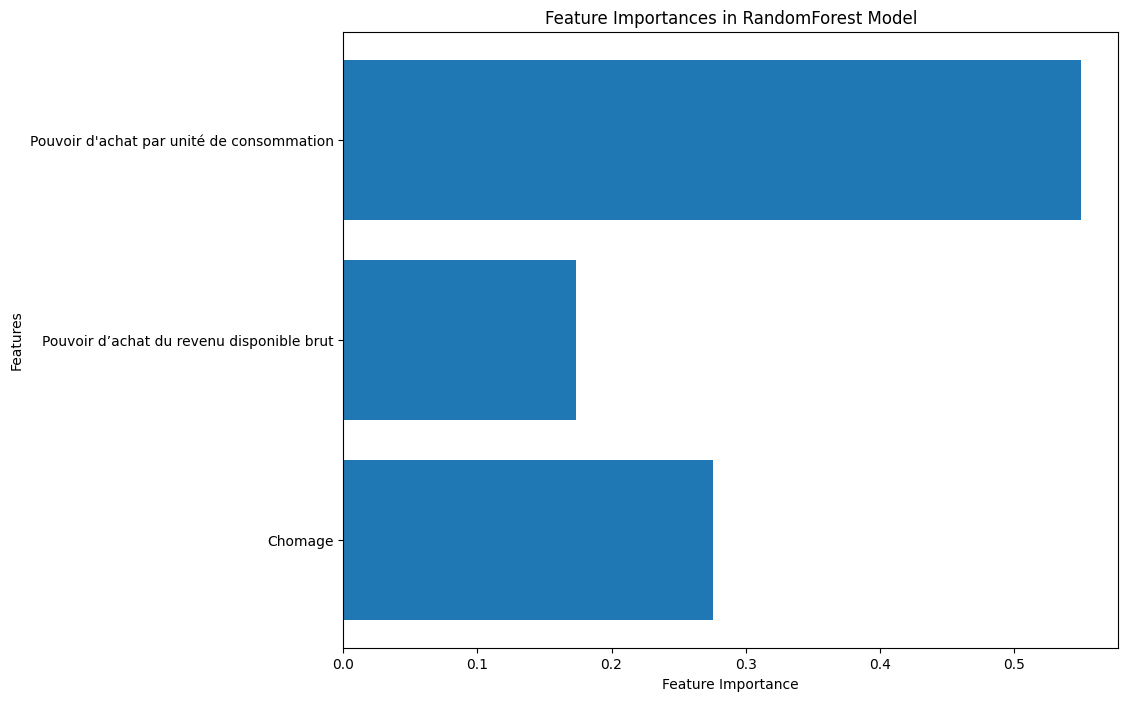

In [31]:
feature_importances = regressor.feature_importances_

plt.figure(figsize=(10, 8))
plt.barh(range(len(feature_importances)), feature_importances, align='center')
plt.yticks(np.arange(len(X_train.columns)), X_train.columns)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances in RandomForest Model')
plt.show()


## Initialisation des Partis et Couleurs
Nous commençons par définir les noms des partis politiques et associons chaque parti à une couleur spécifique pour la visualisation. Ceci est utilisé plus loin dans le code pour maintenir une cohérence visuelle dans les graphiques.

In [32]:
parties = ['Extrême gauche', 'Gauche', 'Droite', 'Extrême droite']
parties_colors = {'Extrême gauche': 'red', 'Gauche': 'green', 'Droite': 'blue', 'Extrême droite': 'purple'}


## Calcul du Nombre Maximum de Classes
Avant de calculer les probabilités moyennes, nous déterminons le nombre maximum de classes existant dans les probabilités prédites. Ceci est nécessaire pour standardiser les calculs ultérieurs sur toutes les listes de probabilités.

In [33]:
max_num_classes = max(len(party_probs[0]) for party_probs in probabilities)

## Calcul des Probabilités Moyennes
Pour chaque parti, nous calculons la probabilité moyenne pour chaque classe de pourcentage. Nous utilisons une liste de compréhension pour traiter chaque classe et chaque probabilité, s'assurant que si une classe n'est pas présente, elle soit comptée comme zéro pour éviter des erreurs de calcul.

In [34]:
mean_probabilities = []
for party_probs in probabilities:
    party_mean_probs = [
        np.mean([proba[class_idx] if class_idx < len(proba) else 0 for proba in party_probs]) 
        for class_idx in range(max_num_classes)
    ]
    mean_probabilities.append(party_mean_probs)

## Ajustement des Étiquettes des Classes
En fonction du nombre maximum de classes déterminé précédemment, nous ajustons les étiquettes des classes pour s'assurer qu'elles correspondent aux données actuelles.

In [35]:
adjusted_classes = ['0-25%', '25-50%', '50-75%', '75-100%'][:max_num_classes]

## Création des Graphiques pour Chaque Classe de Pourcentage
Pour chaque classe de pourcentage, nous créons un graphique à barres qui montre la probabilité moyenne pour chaque parti. Nous utilisons les couleurs prédéfinies pour chaque parti pour améliorer la lisibilité du graphique.

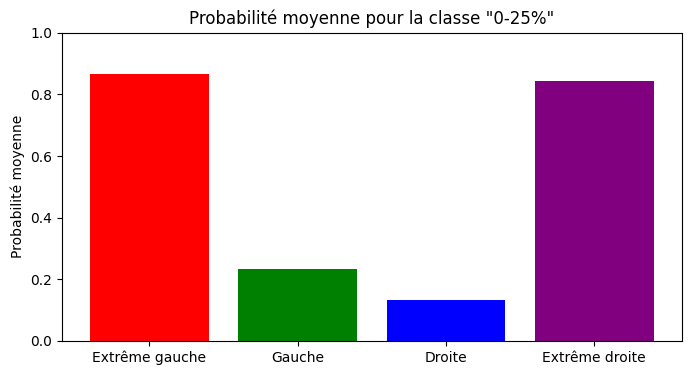

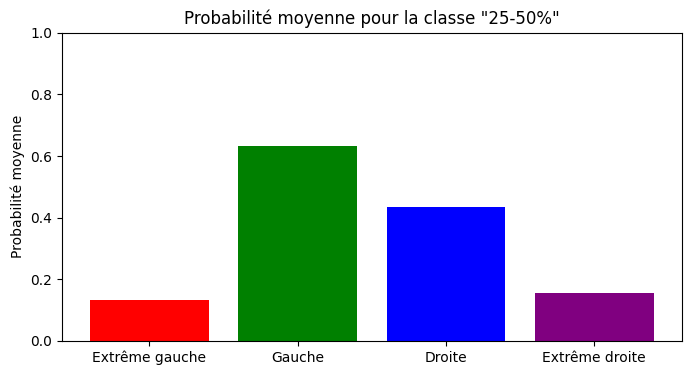

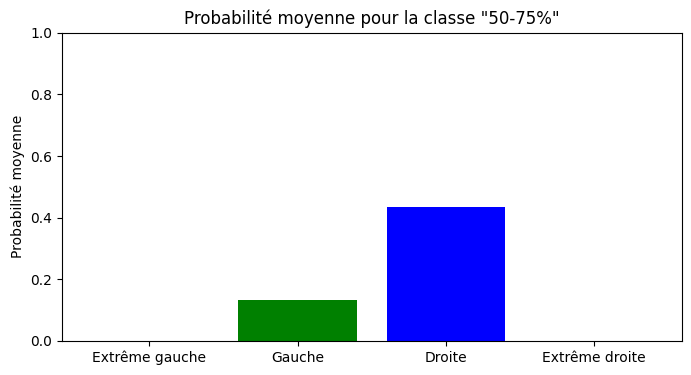

In [36]:
for class_idx, class_label in enumerate(adjusted_classes):
    plt.figure(figsize=(8, 4))
    for i, party in enumerate(parties):
        plt.bar(party, mean_probabilities[i][class_idx], color=parties_colors[party])
    
    plt.title(f'Probabilité moyenne pour la classe "{class_label}"')
    plt.ylabel('Probabilité moyenne')
    plt.ylim(0, 1)
    plt.show()


In [37]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

party_models = {}
party_predictions = {}
party_mse = {}

for party in ['Extrême gauche_Pct', 'Gauche_Pct', 'Droite_Pct', 'Extrême droite_Pct']:
    # Training a model for each party
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train, y_train[party])
    predictions = model.predict(X_test)
    
    # Storing the model and predictions
    party_models[party] = model
    party_predictions[party] = predictions
    
    # Evaluate the model
    mse = mean_squared_error(y_test[party], predictions)
    party_mse[party] = mse
    print(f'MSE for {party}: {mse}')


MSE for Extrême gauche_Pct: 225.7813357609739
MSE for Gauche_Pct: 557.3880081524186
MSE for Droite_Pct: 237.79198968644593
MSE for Extrême droite_Pct: 78.23146736903638


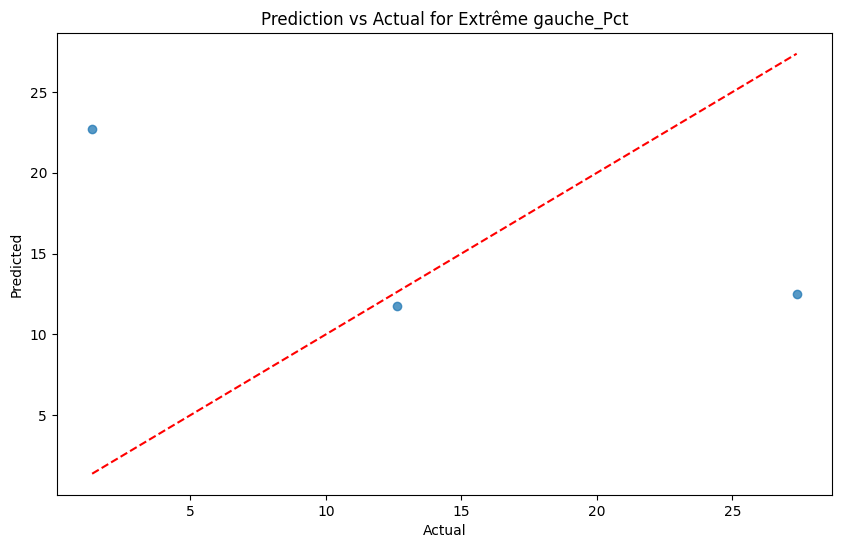

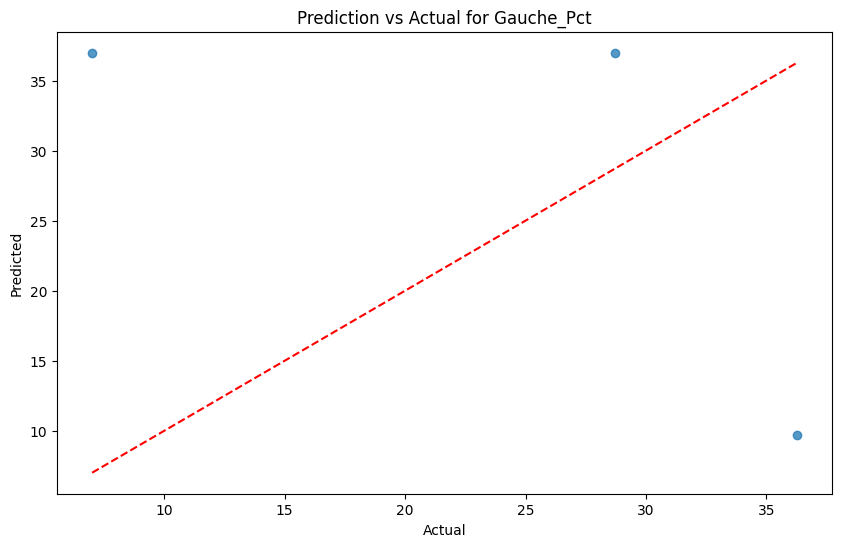

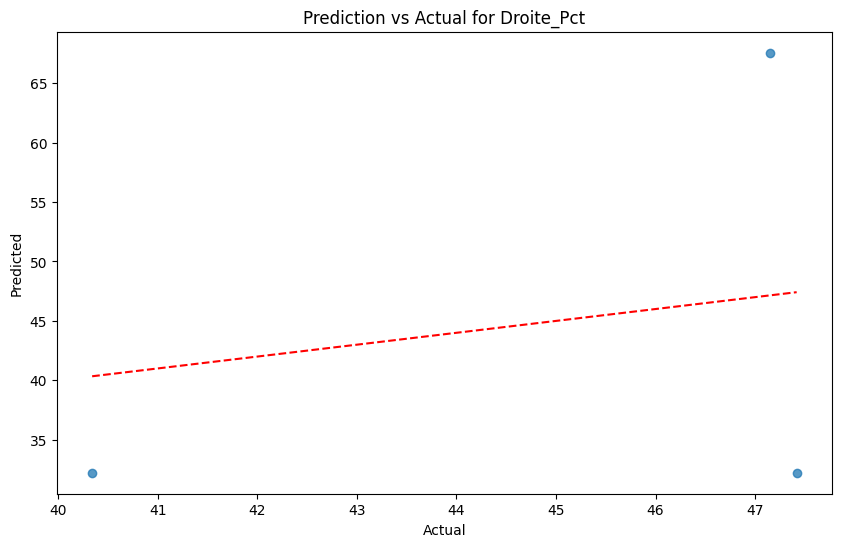

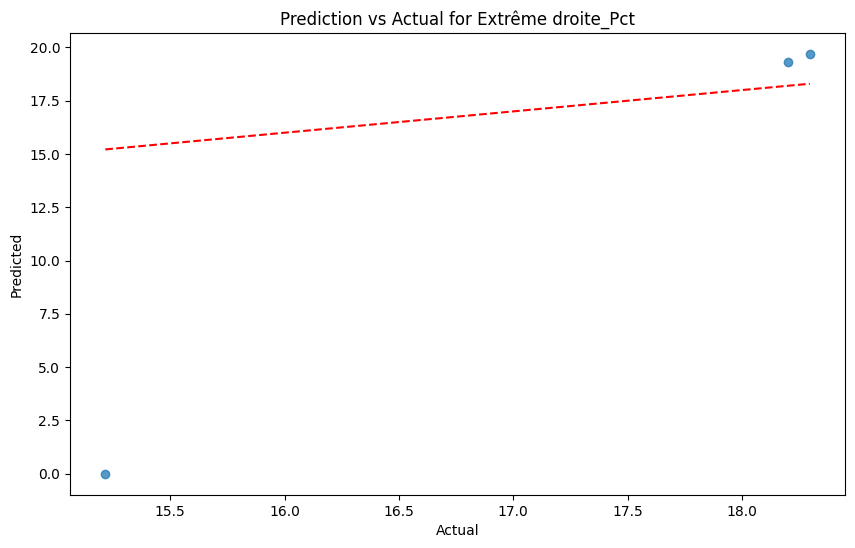

In [38]:
import matplotlib.pyplot as plt

for party in ['Extrême gauche_Pct', 'Gauche_Pct', 'Droite_Pct', 'Extrême droite_Pct']:
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test[party], party_predictions[party], alpha=0.75)
    plt.plot([y_test[party].min(), y_test[party].max()], [y_test[party].min(), y_test[party].max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Prediction vs Actual for {party}')
    plt.show()


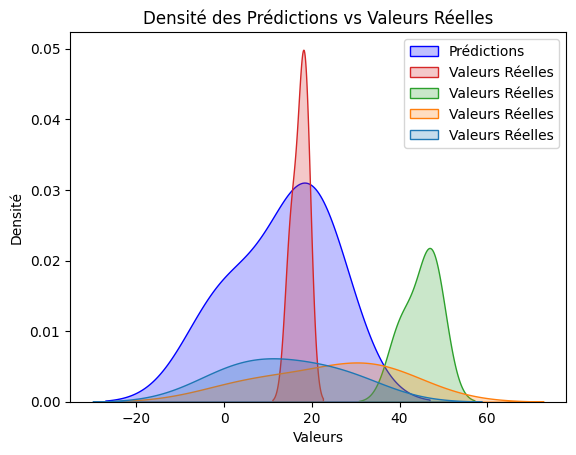

{'Extrême gauche_Pct': GradientBoostingRegressor(random_state=42), 'Gauche_Pct': GradientBoostingRegressor(random_state=42), 'Droite_Pct': GradientBoostingRegressor(random_state=42), 'Extrême droite_Pct': GradientBoostingRegressor(random_state=42)}
{'Extrême gauche_Pct': array([11.74164673, 22.7308934 , 12.52249051]), 'Gauche_Pct': array([36.98742523,  9.703042  , 36.98742523]), 'Droite_Pct': array([32.22611134, 67.56512424, 32.22611134]), 'Extrême droite_Pct': array([1.97057034e+01, 4.35764901e-04, 1.93029237e+01])}
{'Extrême gauche_Pct': 225.7813357609739, 'Gauche_Pct': 557.3880081524186, 'Droite_Pct': 237.79198968644593, 'Extrême droite_Pct': 78.23146736903638}


In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(predictions, label='Prédictions', color='blue', fill=True)  # Updated from `shade=True` to `fill=True`
sns.kdeplot(y_test, label='Valeurs Réelles', color='red', fill=True)  # Updated from `shade=True` to `fill=True`
plt.title('Densité des Prédictions vs Valeurs Réelles')
plt.xlabel('Valeurs')
plt.ylabel('Densité')
plt.legend()
plt.show()



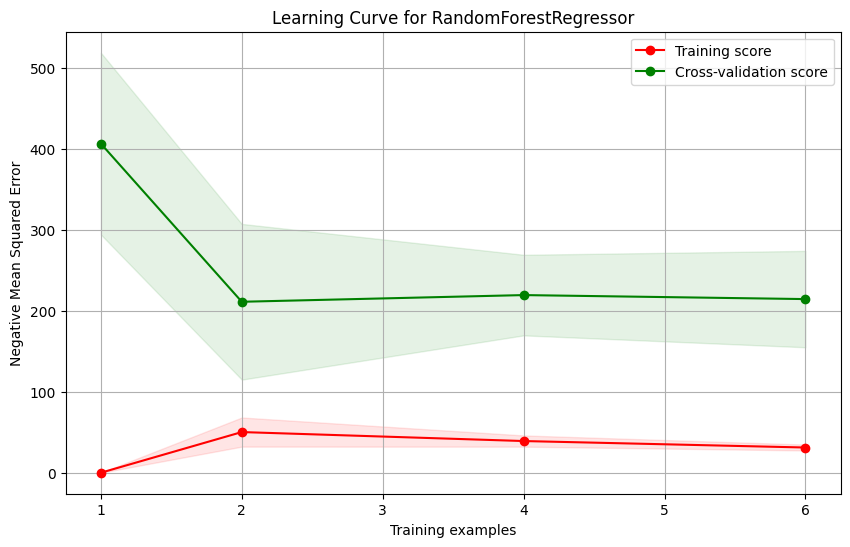

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Assuming X_train and y_train are already defined and are appropriate for regression
train_sizes, train_scores, test_scores = learning_curve(
    RandomForestRegressor(),
    X_train,
    y_train,
    cv=5,  # Using 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Appropriate scoring for regression
    n_jobs=-1,
    train_sizes=[1, 2, 4, 6]  # Ensure this fits within your dataset size
)

# Calculate means and standard deviations
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g", alpha=0.1)
plt.title('Learning Curve for RandomForestRegressor')
plt.xlabel('Training examples')
plt.ylabel('Negative Mean Squared Error')
plt.legend(loc="best")
plt.grid(True)
plt.show()
